In [67]:
import numpy as np
import matplotlib.pyplot as plt


class ZBL():
    def __init__(self, Zi, Zj):
        ''' 
        Class for a ZBL function 
        Zi (int): Charge of species i
        Zj (int): Charge of species j
        '''
    
        self.Zi = Zi
        self.Zj = Zj

        e0 = 55.26349406e-4

        K = 1/(4*np.pi*e0)

        self.a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        self.amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        self.constant = K*Zi*Zj

    def eval_zbl(self, rij):
        '''
        Calculate the ZBL for a given array of pairwise distances
        rij (np.array): array of radial distances
        '''
        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
            
        return (self.constant/rij)*phi

    def eval_grad(self, rij):
        '''
        Calculate the gradient of ZBL for a given array of pairwise distances
        rij (np.array): array of radial distances
        '''
        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(dphi/self.a - phi/rij)
    
    def eval_hess(self, rij):
        '''
        Calculate the second derivative of ZBL for a given array of pairwise distances
        rij (np.array): array of radial distances
        '''

        if isinstance(rij, (int, float)):
            rij = np.array([rij])
            
        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        d2phi = np.sum(self.amplitude*self.exponent**2 * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(d2phi/self.a**2 - 2*dphi/(self.a*rij) + 2*phi/rij**2)
    
def polyfit(x_arr, y_arr, dy_arr, d2y_arr):
    '''
    Fit a polynomial to a set of x, y(x), dy(x) and d2y(x)
    '''
    n_none = 0

    for lst in [y_arr, dy_arr, d2y_arr]:
        
        lst = lst.tolist()
        n_none += lst.count(None)
    
    dof = 3*len(x_arr) - n_none

    Phi = []
    Y   = []

    for i, x in enumerate(x_arr):

        y = y_arr[i]
        dy = dy_arr[i]
        d2y = d2y_arr[i]

        if y is not None:
            Phi.append(np.array([x**i for i in range(dof)]).T)
            Y.append(y)

        if dy is not None:
            Phi.append(np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T)
            Y.append(dy)

        if d2y is not None:
            Phi.append(np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T)
            Y.append(d2y)
        
    Phi = np.array(Phi)

    Y  = np.array(Y)

    return np.linalg.solve(Phi, Y)

def polyval(x, coef, func = True, grad = False, hess = False):
    '''
    Evaluate a polynomial inc first and second derivatives
    '''
    dof = len(coef)

    Phi = np.array([])

    if func:
        Phi = np.array([x**i for i in range(dof)]).T

    elif grad:
        Phi = np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

    elif hess:
        Phi = np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

    if x.ndim == 1:
        return np.dot(Phi, coef)

    else:
        return np.dot(Phi, coef.reshape(-1,1)).flatten()

def splinefit(x_arr, y_arr, dy_arr, d2y_arr):
    '''
    Fit a spline given a set of knot points x_arr, y points y_arr, dy points dy_arr and d2y points d2y_arr
    Will return a list of coefficients which define each spline
    '''
    coef_lst = []

    for i in range(len(x_arr) - 1):
        coef_lst.append(polyfit(x_arr[i:i+2], y_arr[i:i+2], dy_arr[i:i+2], d2y_arr[i:i+2]))
    
    return coef_lst

def splineval(x_arr, coef_lst, knots_pts, func = True, grad = False, hess = False):
    '''
    Given a list of splines and knot points will evaluate the spline at x_arr, if x_arr is outside the bounds will return 0
    '''
    y = np.zeros(x_arr.shape)

    for i ,x in enumerate(x_arr): 
        idx = np.searchsorted(knots_pts, x) - 1

        if 0 <= idx < len(coef_lst):
            y[i] = polyval(x, coef_lst[idx], func, grad, hess).flatten()
        # elif idx < 0:
        #     y[i] = coef_lst[0][0]
        else:
            y[i] = 0
    return y


/var/folders/s9/zg8t26bx2xg094_h3_f559v40000gp/T/ipykernel_99896/2789487559.py:167: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = polyval(x, coef_lst[idx], func, grad, hess).flatten()


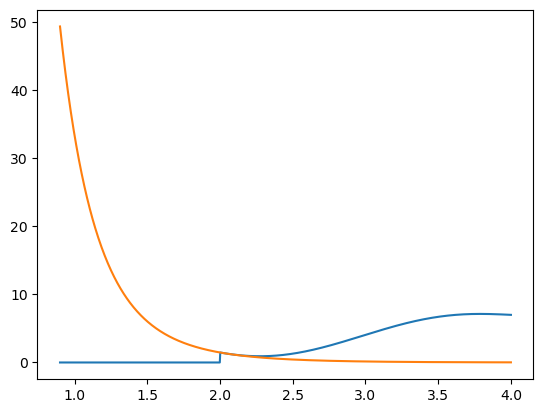

In [ ]:
# Define you ZBL class
zbl_class = ZBL(74, 2)

# Define your knot points - the lower co-ord will fit to ZBL and the higher to EAM
# Ensure both are floats and not integers
xl = 2.0 
xh = 4.0
knot_pts = np.array([xl, xh])

# Calculate the y points from zbl and eam respectively
yl = zbl_class.eval_zbl(xl)
yh = 7.0 
y = np.hstack([yl, yh])

# Calculate the dy points from zbl and eam respectively
dyl = zbl_class.eval_grad(xl)
dyh = -1
dy = np.hstack([dyl, dyh])

# Calculate the d2y points from zbl and eam respectively
d2yl = zbl_class.eval_hess(xl)
d2yh = 0.2
d2y = np.hstack([d2yl, d2yh])

# Fit the spline between those 2 points
coef_lst = splinefit(knot_pts, y, dy, d2y)

# Evaluate the spline in the desired range
x_plt = np.linspace(0.9, 4, 1000)
y_plt = splineval(x_plt, coef_lst, knot_pts )

plt.plot(x_plt, y_plt)

plt.plot(x_plt, zbl_class.eval_zbl(x_plt))

'''
To stitch ZBL to EAM, from a LAMMPS file
 - first read the pair potential and convert to energy by divide by the radius at which that energy is for
 - a cubic interpolation from scipy can be used to interpolate and find gradients and hessians at your stitch points
 - use those stich points for the yh, dyh, d2yh

To write this new file, you would need to evaluate 
 - zbl from 0 + dr to xl
 - spline from xl to xh
 - eam from xh to cutoff

Divide by r and then can be writted to lammps.eam file
'''
